
Student Name : Najmeh Mohajeri
Student ID: 2422386

Read in data in bb.csv. The fourth column contains a value that should be predicted based on three first column values.

Standardise the values (no need to split into training, validation and test sets), and then

* Create a regularised (use sum of weights squared regularisation) model to see the coefficient point estimates
* Create a Bayesian variant of the same model, compare the model parameter means to point estamates and report findings. Record also uncertainty of the parameters (the co-variance matrix sigma).
* Create a Bayesiam model by creating pymc model and sample from it. Use both Normal and Uniform priors for the parameters - are there any differences? Compare the statistics calculated from samples with the previous step and report findings.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pymc as pm
import scipy

from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler

In [3]:
from numpy import genfromtxt
bb_data = genfromtxt('bb.csv', delimiter=',', skip_header= 1)

In [4]:
# test
assert(bb_data.shape[0] == 41)
assert(bb_data.shape[1] == 4)

In [5]:
x = bb_data[:, :-1]
y = bb_data[: , -1]

scaler = StandardScaler().fit(x)
scaled_x = scaler.transform(x)

In [6]:
model_ridge = Ridge(alpha=1.0).fit(scaled_x, y)
print("Ridge Regression Coefficients:")
print(model_ridge.coef_)

Ridge Regression Coefficients:
[ 1.36620647  2.20515635 -8.1574815 ]


In [7]:
model_bayesianridge = BayesianRidge().fit(scaled_x, y)
print("\nBayesian Ridge Regression Coefficients:")
print(model_bayesianridge.coef_)
print("\nBayesian Ridge Regression Sigma:")
print(model_bayesianridge.sigma_)


Bayesian Ridge Regression Coefficients:
[ 1.32636309  2.17128745 -8.0869954 ]

Bayesian Ridge Regression Sigma:
[[ 0.95043457  0.3382528  -0.27851736]
 [ 0.3382528   0.88671839 -0.15343899]
 [-0.27851736 -0.15343899  0.84795397]]


In [8]:
normal_model = pm.Model()
with normal_model:
    # Priors for unknown model parameters (Normal)
    w0 = pm.Normal('w0', mu=0, sigma=1)
    w1 = pm.Normal('w1', mu=0, sigma=1)
    w2 = pm.Normal('w2', mu=0, sigma=1)
    w3 = pm.Normal('w3', mu=0, sigma=1)

    mu = w0 + w1 * scaled_x[:, 0] + w2 * scaled_x[:, 1] + w3 * scaled_x[:, 2]

    y_obs = pm.Normal('y_obs', mu=mu, sigma=1, observed=y)


    normal_trace = pm.sample(3000, tune=2000, return_inferencedata=True)

Output()

Output()

In [13]:
print(np.mean(normal_trace.posterior['w0'].values))
print(np.mean(normal_trace.posterior['w1'].values))
print(np.mean(normal_trace.posterior['w2'].values))
print(np.mean(normal_trace.posterior['w3'].values))

18.662123427020322
1.3642967187045694
2.2028067220754624
-8.155947119124583


In [19]:
uniform_model = pm.Model()

with uniform_model:
    w0 = pm.Uniform('w0', lower=10, upper=20)
    w1 = pm.Uniform('w1', lower=0, upper=2)
    w2 = pm.Uniform('w2', lower=0, upper=3)
    w3 = pm.Uniform('w3', lower=-10, upper=0)

    mu = w0 + w1 * scaled_x[:, 0] + w2 * scaled_x[:, 1] + w3 * scaled_x[:, 2]

    y_obs = pm.Normal('y_obs', mu=mu, sigma=1, observed=y)


    uniform_trace = pm.sample(3000, tune=2000, return_inferencedata=True)


Output()

Output()

In [20]:
print(np.mean(uniform_trace.posterior['w0'].values))
print(np.mean(uniform_trace.posterior['w1'].values))
print(np.mean(uniform_trace.posterior['w2'].values))
print(np.mean(uniform_trace.posterior['w3'].values))

19.11256695401181
1.5103002574501163
2.3288034595034794
-8.40526444421188


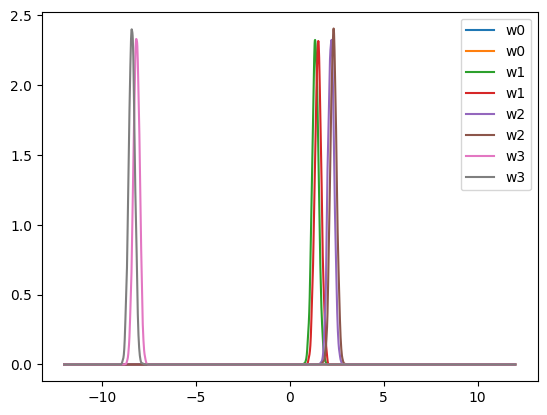

In [21]:
traces = [normal_trace, uniform_trace]
xs = np.linspace(-12, 12, 2000)

for w in ['w0','w1', 'w2', 'w3']:
    for i, trace in enumerate(traces):
        samples = trace.posterior[w].values.flatten()
        ys = scipy.stats.gaussian_kde(samples)(xs)
        plt.plot(xs, ys, label=f'{w}')

plt.legend()
plt.show()